In [1]:
import pandas as pd

# Load the datasets
customers_df = pd.read_csv("Customers.csv")
products_df = pd.read_csv("Products.csv")
transactions_df = pd.read_csv("Transactions.csv")


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# Merge transaction data with customer details
customer_transactions = transactions_df.merge(customers_df, on="CustomerID")

# Aggregate data at customer level
customer_features = customer_transactions.groupby("CustomerID").agg({
    "TotalValue": "sum",  # Total spending
    "Quantity": "sum",  # Total items bought
    "TransactionID": "count"  # Number of transactions
}).rename(columns={"TransactionID": "TransactionCount"}).reset_index()

# Normalize the data for similarity calculations
scaler = StandardScaler()
customer_features_scaled = scaler.fit_transform(customer_features.iloc[:, 1:])



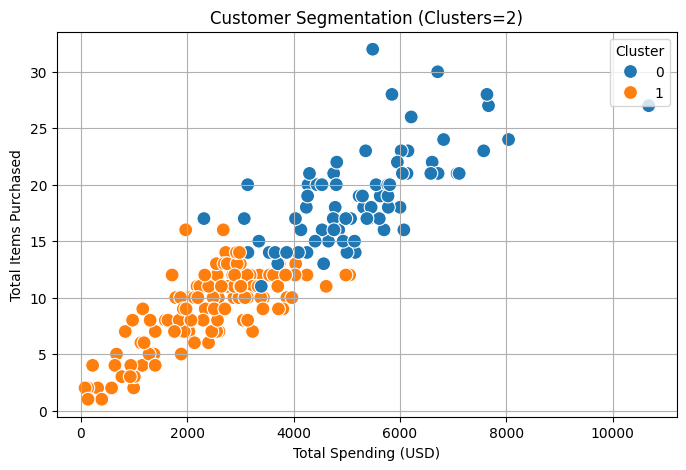

(2, 0.7233652695141874)

In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import davies_bouldin_score

# Determine the optimal number of clusters using the Davies-Bouldin Index
db_scores = {}
for k in range(2, 11):  # Testing clusters from 2 to 10
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(customer_features_scaled)
    db_index = davies_bouldin_score(customer_features_scaled, clusters)
    db_scores[k] = db_index

# Find the optimal number of clusters
optimal_clusters = min(db_scores, key=db_scores.get)

# Apply KMeans with the optimal cluster count
kmeans_final = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
customer_features["Cluster"] = kmeans_final.fit_predict(customer_features_scaled)

# Calculate Davies-Bouldin Index for the final clustering
final_db_index = davies_bouldin_score(customer_features_scaled, customer_features["Cluster"])

# Visualize the clusters
plt.figure(figsize=(8, 5))
sns.scatterplot(x=customer_features["TotalValue"], y=customer_features["Quantity"], hue=customer_features["Cluster"], palette="tab10", s=100)
plt.title(f"Customer Segmentation (Clusters={optimal_clusters})")
plt.xlabel("Total Spending (USD)")
plt.ylabel("Total Items Purchased")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

# Save clustering results
clustering_report_path = "Clustering_Report.csv"
customer_features.to_csv(clustering_report_path, index=False)


# Output DB Index value
optimal_clusters, final_db_index


Cluster counts:
 Cluster
5    37
4    30
1    29
3    27
2    27
7    20
6    16
0    13
Name: count, dtype: int64
Davies-Bouldin Index: 1.0612573698816168
Average Silhouette Score: 0.2709
Number of clusters formed: 8


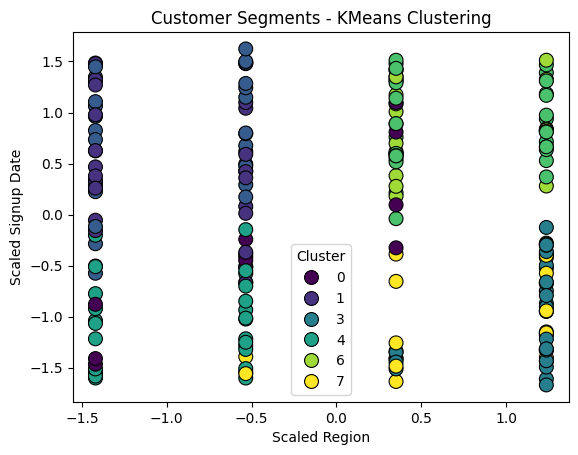

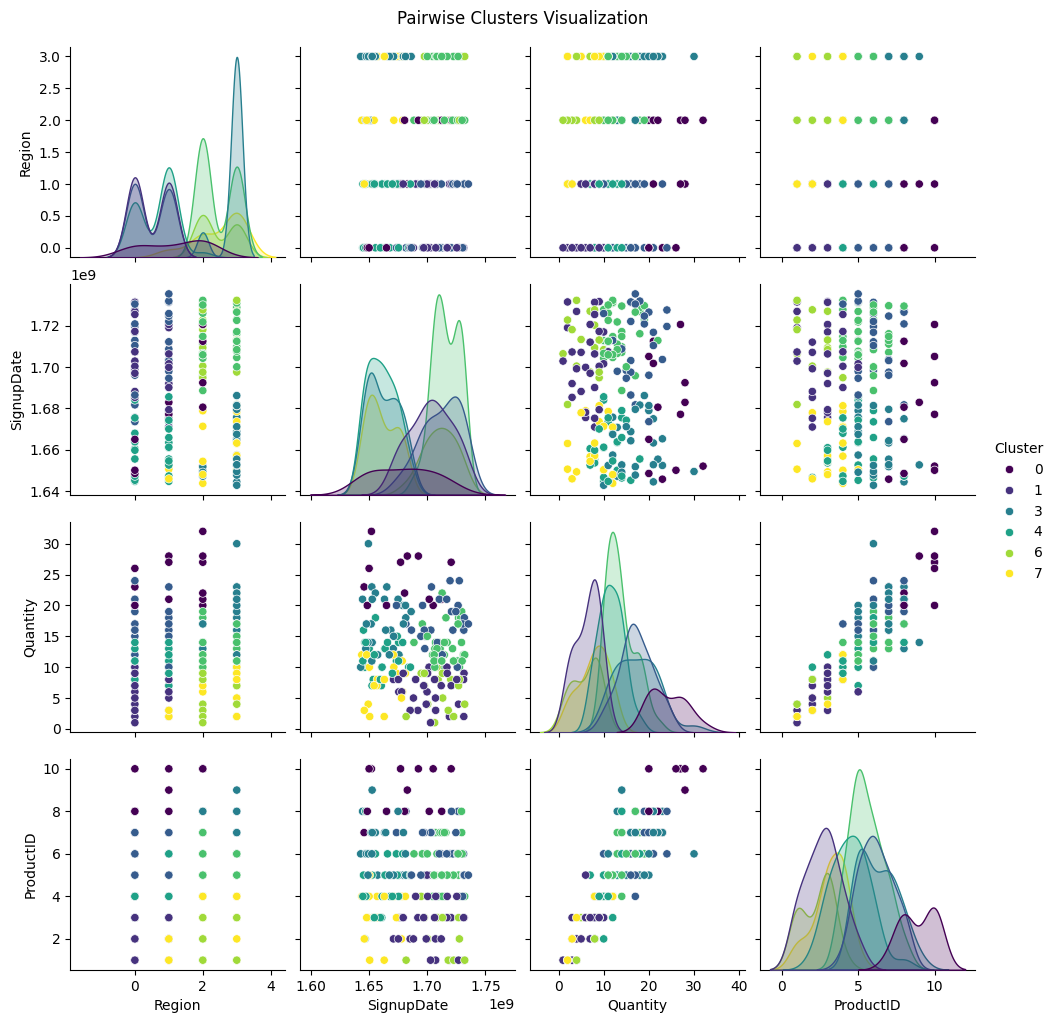

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load datasets
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

# Preprocessing for customers
# Encode 'Region' using Label Encoding
le = LabelEncoder()
customers['Region'] = le.fit_transform(customers['Region'])

# Convert 'SignupDate' to Unix timestamp
customers['SignupDate'] = pd.to_datetime(customers['SignupDate']).apply(lambda x: x.timestamp())

# Merge customer and transaction data
merged_data = transactions.merge(customers, on='CustomerID')

# Aggregate transaction data to get total quantity spent per customer
customer_transaction_data = merged_data.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'ProductID': 'nunique'
}).reset_index()

# Combine the profile and transaction data for clustering
features = pd.merge(customers[['CustomerID', 'Region', 'SignupDate']], customer_transaction_data, on='CustomerID')

# Select features for clustering
clustering_features = features[['Region', 'SignupDate', 'Quantity', 'ProductID']]

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features)

# Test multiple cluster counts and evaluate metrics
db_scores = {}
silhouette_scores = {}
for k in range(2, 11):  # Testing clusters from 2 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)
    db_scores[k] = davies_bouldin_score(scaled_features, clusters)
    silhouette_scores[k] = silhouette_score(scaled_features, clusters)

# Determine optimal clusters based on Davies-Bouldin Index
optimal_clusters = min(db_scores, key=db_scores.get)
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Add cluster labels to the dataset
features['Cluster'] = clusters

# Display cluster counts
print("Cluster counts:\n", features['Cluster'].value_counts())

# Calculate Davies-Bouldin Index and Silhouette Score for optimal clustering
db_index = davies_bouldin_score(scaled_features, clusters)
silhouette_avg = silhouette_score(scaled_features, clusters)
print("Davies-Bouldin Index:", db_index)
print(f"Average Silhouette Score: {silhouette_avg:.4f}")
print(f"Number of clusters formed: {optimal_clusters}")

# Visualize clusters
sns.scatterplot(
    x=scaled_features[:, 0],
    y=scaled_features[:, 1],
    hue=features['Cluster'],
    palette='viridis',
    s=100, edgecolor='black'
)
plt.title("Customer Segments - KMeans Clustering")
plt.xlabel("Scaled Region")
plt.ylabel("Scaled Signup Date")
plt.legend(title="Cluster")
plt.show()



# Pairplot for multidimensional visualization of clusters
sns.pairplot(features, vars=['Region', 'SignupDate', 'Quantity', 'ProductID'], hue='Cluster', palette='viridis')
plt.suptitle("Pairwise Clusters Visualization", y=1.02)
plt.show()